## Fit 3D Variogram Functions

The 3D Gaussian variogram function has the following form:

$\gamma = s(1 - e^{-3h^{\top} \Omega h} + 0.06e^{-7.07h^{\top} \Omega h})$

where $\Omega$ is a diagonal matrix with diagonal terms $= [\frac{1}{{r_{lon}}^2}, \frac{1}{{r_{lat}}^2}, \frac{1}{{r_{time}}^2}]$

In [1]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.variogram.VariogramFitting import VariogramFitting
import pandas as pd
import os

# read in 2D/3D variogram data
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_tuned"
file_name = "tuned_2d_forecast_variogram_area1_[5.0, 1.0]_False_True.npy"
file_path = os.path.join(save_dir, file_name)
data = pd.read_csv(file_path)
data

,space_lag,t_lag,u_semivariance,v_semivariance,detrend_u,detrend_v
0,40,10,0.366261,0.444371,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
1,40,20,0.568716,0.615804,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
2,40,30,0.427120,0.510580,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
3,40,40,0.567815,0.614435,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
4,40,50,0.600576,0.655143,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
...,...,...,...,...,...,...
1495,1000,560,1.034056,1.005089,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
1496,1000,570,1.061431,1.019589,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
1497,1000,580,1.076456,1.014321,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"
1498,1000,590,1.079719,1.027051,"[-0.07340458968161157, 0.1958211191508395]","[-0.03787128905927239, 0.2073627648561399]"


In [30]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
# list of optimization algorithms: https://lmfit.github.io/lmfit-py/fitting.html
fitted_v.fit_model(4, method="emcee", constrain_weighting=True)  # emcee, leastsq, leastsquare

Number of models: 4
Type of model: gaussian_2d


100%|██████████| 1000/1000 [00:31<00:00, 32.22it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [104.94946689 108.24897709 105.89011626 105.41553583  98.46973142
  99.14568502  98.35017254 103.22389109 104.66953119 109.91318375
 101.63092058]
Parameters:
 [[1.32501994e-01 2.36333675e+02 3.23297310e+02]
 [2.62640431e-01 7.11750364e+01 1.31075471e+02]
 [1.35088656e-01 1.45844995e+02 1.62455587e+02]
 [4.69768919e-01 1.36698352e+02 1.26606065e+02]]


[[1.32501994e-01 2.36333675e+02 1.00000000e+01]
 [2.62640431e-01 7.11750364e+01 2.00000000e+01]
 [1.35088656e-01 1.45844995e+02 6.00000000e+01]
 [4.69768919e-01 1.36698352e+02 6.00000000e+02]]


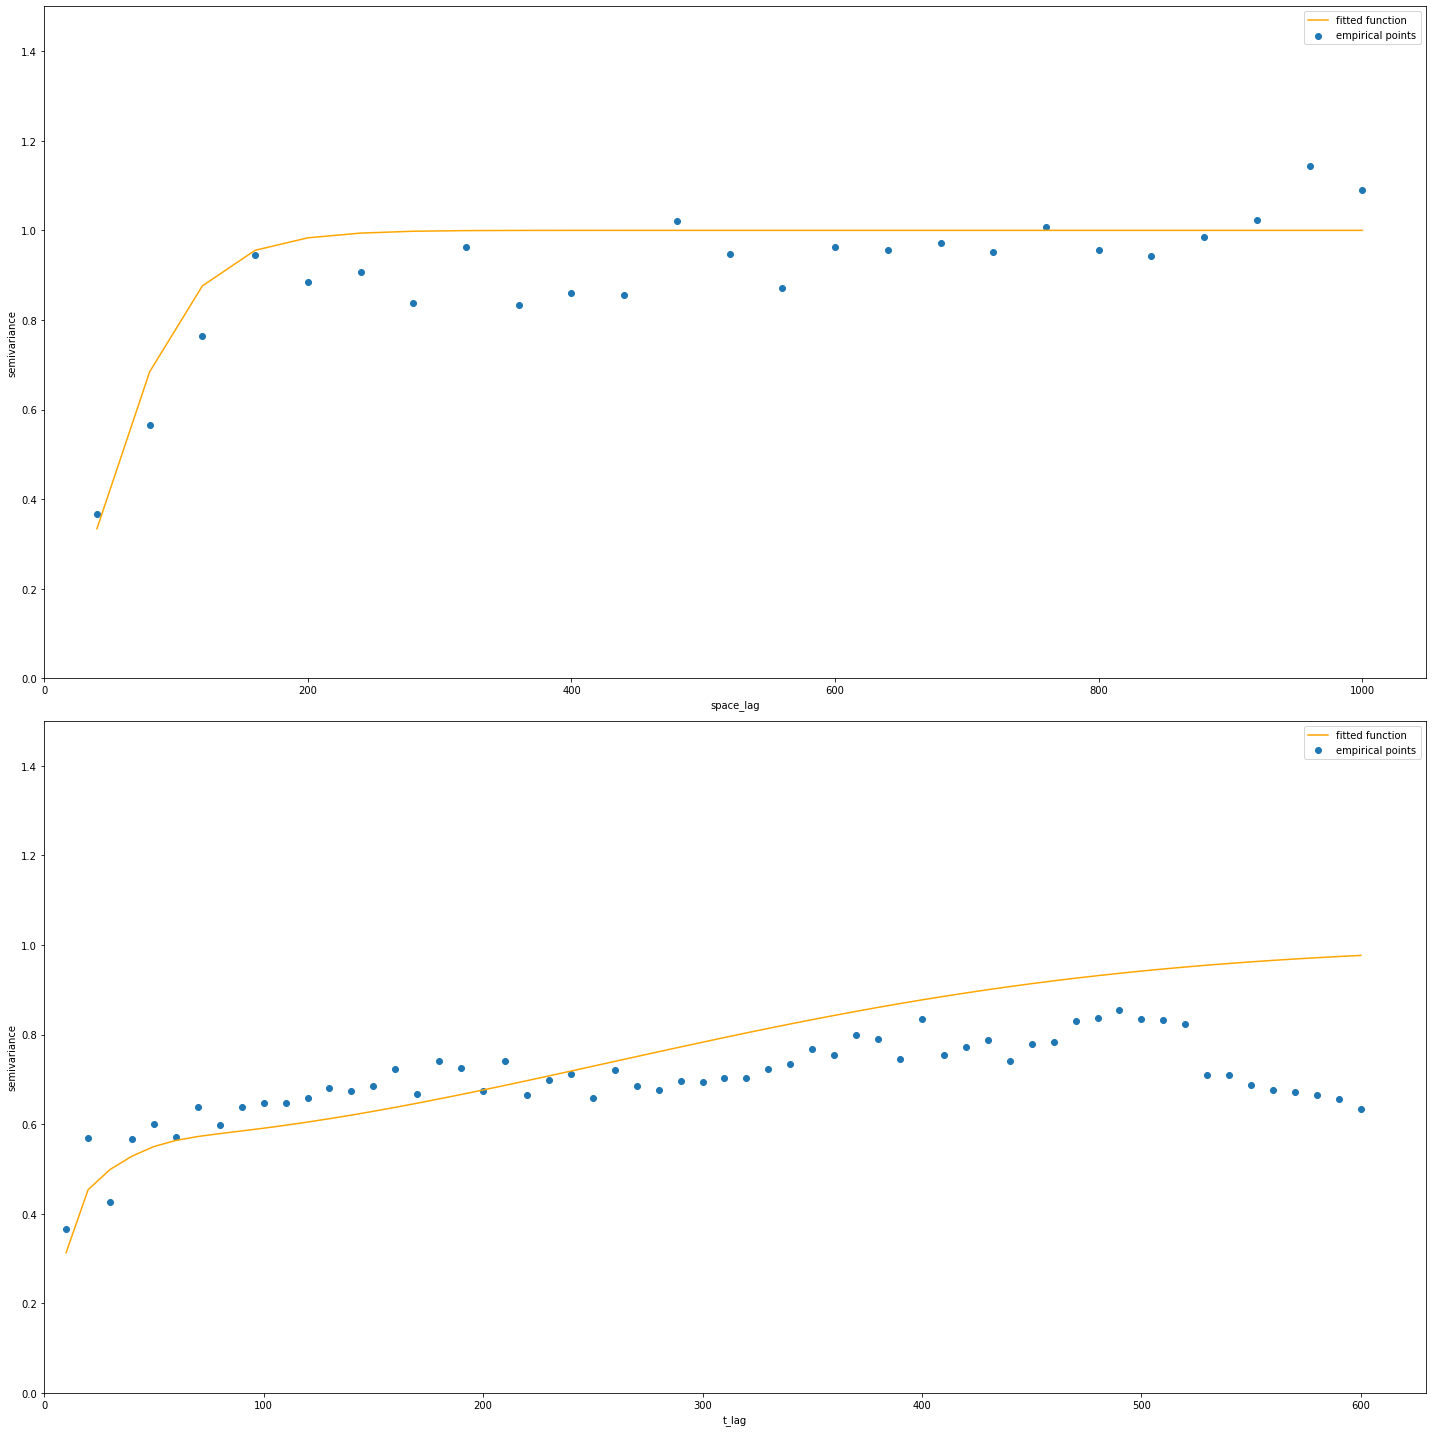

In [40]:
save_path = f"/home/jonas/Downloads/plots/fitted_func_only_cross_buoy.png"
figure = fitted_v.plot_all_dims(save_path=None)
print(fitted_v.popt)

In [41]:
# save parameters
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_params"
fitted_v.save_params(os.path.join(save_dir, file_name))

Saved {'U_COMP': [array([1.32501994e-01, 2.36333675e+02, 2.36333675e+02, 1.00000000e+01]), array([ 0.26264043, 71.1750364 , 71.1750364 , 20.        ]), array([1.35088656e-01, 1.45844995e+02, 1.45844995e+02, 6.00000000e+01]), array([4.69768919e-01, 1.36698352e+02, 1.36698352e+02, 6.00000000e+02])], 'V_COMP': [array([ 0.18493062, 68.58801539, 68.58801539, 10.        ]), array([ 0.36806672, 62.49306083, 62.49306083, 20.        ]), array([1.12179419e-01, 2.66554404e+02, 2.66554404e+02, 2.82915848e+02]), array([3.34823242e-01, 2.55686469e+02, 2.55686469e+02, 5.24269210e+02])], 'detrend_metrics': [[-0.06289971241477924, 0.18389570704293642], [-0.05369093828929817, 0.17574689245404426]]}


## Plot model from parameters

Number of models: 4
Type of model: gaussian_2d
[[1.32501994e-01 2.36333675e+02 1.00000000e+01]
 [2.62640431e-01 7.11750364e+01 2.00000000e+01]
 [1.35088656e-01 1.45844995e+02 6.00000000e+01]
 [4.69768919e-01 1.36698352e+02 6.00000000e+02]]


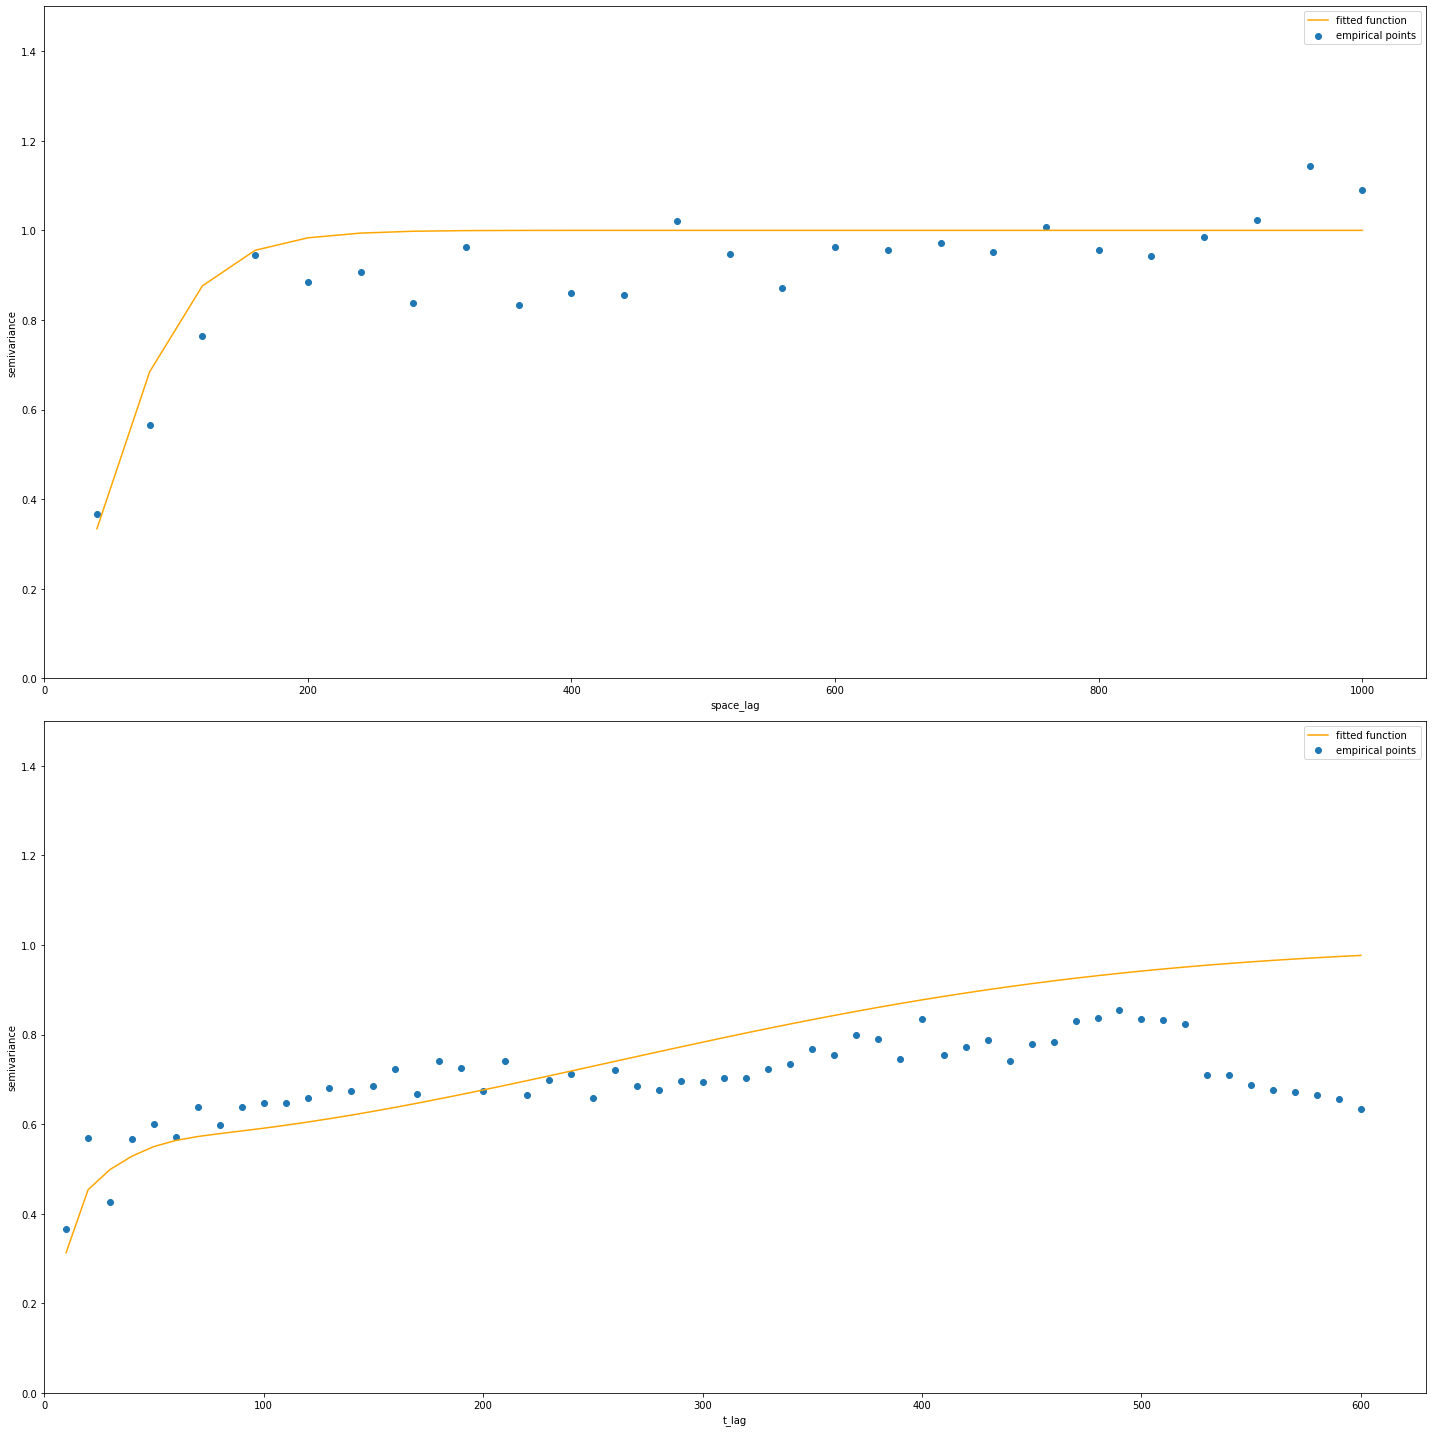

In [43]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
fitted_v.load_params("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_[5.0, 1.0]_False_True.npy")
fitted_v.plot_all_dims(plot_empirical=True)
print(fitted_v.popt)